# Analyzing and improving Pittsburgh bus time predictions

## Introduction
<table width="100%">
<tr>
    <td>Transit, Whiz, Pittsburgh... All the apps providing real-time bus predictions in Pittsburgh actually use the same source of information. More precisely, they use the official PAT API named <a href="https://truetime.portauthority.org/bustime/home.jsp">BusTime</a>. <br />Knowing how useful predicting buses arrival times is and how many people use those predictions in their daily life, how accurate are they?<br />In this project I will try to answer this question for the route 61 of Pittsburgh bus network, as it is probably the most used route by CMU students. </td>
    <td><img src="transit_app.png" alt="Drawing" style="width: 256px;"/></td>
</tr>
</table>

## Table of contents
This project is divided in three parts:
- Data Collection
- Data Visualisation
- Predictive Modeling

These parts are not independant, please execute all the cells in order.

## Part 1: Data Collection
All the libraries used in this part are pretty standard except the type annotations that require Python 3.5+.

In [161]:
import json
import time
import os
from typing import Dict, Tuple, List

import requests
import pandas as pd

### Retrieve a Bustime API key
Anyone can request an API key pretty easily by signing up [here](https://truetime.portauthority.org/bustime/home.jsp) and accessing the `Developer API` page.

**Hint**: if you want a key only to read this notebook you can easily get the one used by the [publicly available interface](https://truetime.portauthority.org/home) by snooping on network traffic in the developer tools of your browser. **Use this key responsibly.**

Once you have a key please write it below or use an environment variable named `BUSTIME_API_KEY`

In [2]:
BUSTIME_API_KEY = os.getenv('BUSTIME_API_KEY')

# Keep track of the number of requests we make as there is a 10k daily limit
CALLS_COUNT = 0

### General query setup
Using the [API documentation](https://truetime.portauthority.org/bustime/apidoc/docs/DeveloperAPIGuide3_0.pdf) we can write basic query routines and global variables

In [3]:
BASE_URL = 'http://realtime.portauthority.org/bustime/api/v3'

# DATAFEED_NAME can be obtained by querying the '/getrtpidatafeeds' endpoint
# see Appendix for more information
DATAFEED_NAME = 'Port Authority Bus'

VEHICLES_ENDPOINT = '/getvehicles'
ROUTES_ENDPOINT = '/getroutes'
PATTERNS_ENDPOINT = '/getpatterns'
DIRECTIONS_ENDPOINT = '/getdirections'
STOPS_ENDPOINT = '/getstops'
PREDICTIONS_ENDPOINT = '/getpredictions'

In [12]:
def query_api(endpoint: str, params: Dict[str, str]={}) -> Dict:
    """
    Query the BusTime API on the provided endpoint with the provided parameters.
    The key, format and rpidatafeed parameters will automatically be added
    to the parameters.
    
    'endpoint' has to be one of the globally defined endpoints
    """    
    
    params['key'] = BUSTIME_API_KEY
    params['format'] = 'json'
    params['rtpidatafeed'] = DATAFEED_NAME
    
    response = requests.get(BASE_URL + endpoint,
                            params=params)
    global CALLS_COUNT
    CALLS_COUNT += 1
    
    if response.status_code == 200:
        # Responses are always contained in the 'bustime-response' object
        return json.loads(response.text)['bustime-response']
    else:
        print(response.status_code, response.text)
        return None

### Querying general information

#### Routes

Retrieve a list of possible route ids to be used when querying the API.

In [11]:
def get_routes() -> List[Dict]:
    params = {}
    
    raw_routes = query_api(ROUTES_ENDPOINT, params)['routes']
    
    routes = { r['rt']: { 'name': r['rtnm'], 'color': r['rtclr'] } for r in raw_routes }
    
    return routes    

In [6]:
print(', '.join(get_routes().keys()))

1, 11, 12, 13, 14, 15, 16, 17, 18, 19L, 2, 20, 21, 22, 24, 26, 27, 28x, 29, 31, 36, 38, 39, 4, 40, 41, 43, 44, 48, 51, 51L, 52L, 53, 53L, 54, 55, 56, 57, 58, 59, 6, 60, 61A, 61B, 61C, 61D, 64, 65, 67, 68, 69, 7, 71, 71A, 71B, 71C, 71D, 74, 75, 77, 79, 8, 81, 82, 83, 86, 87, 88, 89, 91, 93, G2, G3, G31, O1, O12, O5, P1, P10, P12, P13, P16, P17, P2, P3, P67, P68, P69, P7, P71, P76, P78, Y1, Y45, Y46, Y47, Y49


#### Bus locations (or Vehicles)

In [125]:
def get_vehicles(route_ids: str) -> List[Dict]:
    """
    Retrieve all the running buses on the specified route ids.
    
    route_ids is a comma-separated list of up to 10 route ids.
    Example: '61A,61B,71D'
    
    Return a list of vehicles as a list of dicts.
    """
    
    params = {}
    params['rt'] = route_ids
    params['tmres'] = 's'
    
    response = query_api(VEHICLES_ENDPOINT, params)
    
    if response is None or 'vehicle' not in response:
        print('Couldn\'t retrieve vehicles', response)
        return []
    
    raw_vehicles = response['vehicle']
    
    # Refer to the documentation for more information
    vehicles = [{'id': v['vid'],
                 'timestamp': v['tmstmp'],
                 'lat': v['lat'],
                 'lon': v['lon'],
                 'destination': v['des'],
                 'pattern_id': v['pid'],
                 'pattern_distance': v['pdist'],
                 'trip_id': v['tatripid'],
                 'speed': v['spd'],
                 'passenger_load': v['psgld']} for v in raw_vehicles]
                 
    return vehicles    

In [10]:
vehicles = get_vehicles('61A')
pd.DataFrame(vehicles)

,id,timestamp,lat,lon,destination,pattern_id,pattern_distance,trip_id,speed,passenger_load
0,6443,20191211 20:30:15,40.415289306640624,-79.87563591003418,Downtown,6912,18197,5769,20,HALF_EMPTY
1,3247,20191211 20:30:05,40.44278738839286,-79.95502580915179,Braddock,6914,14734,6779,7,HALF_EMPTY
2,6336,20191211 20:30:14,40.43362933486255,-79.88422120507084,Braddock,6914,43131,6775,0,HALF_EMPTY


#### Predictions

In [17]:
def get_predictions(vehicle_ids: str) -> List[Dict]:
    params = {}
    
    params['vid'] = vehicle_ids 
    params['tmres'] = 's'
    
    response = query_api(PREDICTIONS_ENDPOINT, params)
    
    if response is None or 'prd' not in response:
        print('Couldn\'t retrieve predictions', response)
        return []
    
    raw_predictions = response['prd']
    
    # Refer to the documentation for more information
    predictions = [{'timestamp': p['tmstmp'],
                    'stop_id': p['stpid'],
                    'vehicle_id': p['vid'],
                    'predicted_time': p['prdtm'],
                    'trip_id': p['tatripid'],
                    'distance_to_stop': p['dstp']} for p in raw_predictions if p['typ'] == 'A']
    
    return predictions

In [18]:
def get_predictions_for_vehicles(vehicles: List[Dict]) -> List[Dict]:
    """
    Gather the predictions for all the vehicles 10 by 10
    """

    total_predictions = []

    for i in range(0, len(vehicles), 10):
        total_predictions += get_predictions(','.join([str(v['id']) for v in vehicles[i:min(i + 10, len(vehicles))]]))

    return total_predictions

In [19]:
predictions = get_predictions_for_vehicles(get_vehicles('61A'))
pd.DataFrame(predictions)

,timestamp,stop_id,vehicle_id,predicted_time,trip_id,distance_to_stop
0,20191211 20:33:01,7062,6443,20191211 20:33:22,5769,473
1,20191211 20:33:15,7117,3247,20191211 20:33:25,6779,253
2,20191211 20:33:04,7156,6336,20191211 20:33:31,6775,546
3,20191211 20:33:15,7119,3247,20191211 20:34:01,6779,1130
4,20191211 20:33:04,7157,6336,20191211 20:34:03,6775,928
...,...,...,...,...,...,...
128,20191211 20:33:01,34,6443,20191211 21:01:43,5769,35303
129,20191211 20:33:15,7170,3247,20191211 21:02:06,6779,37604
130,20191211 20:33:15,7171,3247,20191211 21:02:28,6779,38210
131,20191211 20:33:01,35,6443,20191211 21:02:30,5769,36048


#### Stops

In [20]:
def get_stops_for_patterns(pattern_ids: str):
    """
    pattern_ids is a comma-separated list of up to 10 pattern ids.
    Example: '2189,17389,1111'
    """
    
    params = { 'pid': pattern_ids }
    
    response = query_api(PATTERNS_ENDPOINT, params)
    
    if response is None or 'ptr' not in response:
        print('Couldn\'t retrieve stops', response)
        return {}
    
    raw_patterns = response['ptr']
    
    patterns = {}

    for p in raw_patterns:
        pattern_stops = []
        points = p['pt']

        for point in points:
            # Only look for stop information
            if point['typ'] == 'S':
                pattern_stops.append({'id': int(point['stpid']),
                                      'name': point['stpnm'],
                                      'distance': point['pdist'],
                                      'lat': point['lat'],
                                      'lon': point['lon']})
    
        # Shouldn't be necessary but better safe than sorry
        patterns[p['pid']] = sorted(pattern_stops, key=lambda x: x['distance'])
        
    return patterns

In [21]:
def get_stops_for_more_than_10_patterns(pattern_ids: List[str]):
    """
    Query the stops for patterns, 10 at a time
    """
    
    total_patterns = {}

    for i in range(0, len(pattern_ids), 10):
        total_patterns.update(get_stops_for_patterns(','.join(pattern_ids[i:min(i + 10, len(pattern_ids))])))

    return total_patterns

### Collecting data

In [22]:
import time
import pandas as pd
from tqdm import tqdm

In [23]:
ROUTE_IDS = '61A,61B'

In [25]:
# See gather_predictions.py for the real, stand-alone API gatherer

number_iterations = 5
predictions = []
vehicles = []

for i in tqdm(range(number_iterations)):
    vehicles_now = get_vehicles(ROUTE_IDS)
    
    predictions += get_predictions_for_vehicles(vehicles_now)
    vehicles += vehicles_now
    
    time.sleep(5)

print(f'Called the API {CALLS_COUNT} times.')

100%|██████████| 5/5 [00:27<00:00,  5.51s/it]

Called the API 24 times.


In [27]:
pd.DataFrame(predictions).head()

,timestamp,stop_id,vehicle_id,predicted_time,trip_id,distance_to_stop
0,20191211 20:33:33,7237,3248,20191211 20:34:03,6777,850
1,20191211 20:33:31,7063,6443,20191211 20:34:04,5769,578
2,20191211 20:33:31,7064,6443,20191211 20:34:24,5769,904
3,20191211 20:33:33,7238,3248,20191211 20:34:27,6777,1549
4,20191211 20:33:54,3241,6112,20191211 20:34:29,6781,593


In [28]:
pd.DataFrame(vehicles).head()

,id,timestamp,lat,lon,destination,pattern_id,pattern_distance,trip_id,speed,passenger_load
0,6443,20191211 20:33:30,40.419417104413434,-79.8848146007907,Downtown,6912,21401,5769,12,HALF_EMPTY
1,3247,20191211 20:33:45,40.44464111328125,-79.94328308105469,Braddock,6914,18213,6779,0,HALF_EMPTY
2,6336,20191211 20:33:34,40.42319523204457,-79.88641426780008,Braddock,6914,47268,6775,0,HALF_EMPTY
3,6112,20191211 20:33:10,40.43898010253906,-79.99569702148438,Braddock Hills Shopping Ctr,6776,1600,6781,0,EMPTY
4,3248,20191211 20:33:32,40.43826467340643,-79.89705403645833,Braddock,6777,33245,6777,19,HALF_EMPTY


## Part 2: Analyzing data

In [162]:
from bisect import bisect_right
import matplotlib.pyplot as plt
from mapboxgl.utils import *
from mapboxgl.viz import *
import math

%matplotlib inline

Obtain a free MapBox API key here https://www.mapbox.com/.

In [163]:
MAPBOX_API_KEY = os.getenv('MAPBOX_API_KEY')
PITTSBURGH_COORDINATES = (-79.9344456246, 40.4177995781)

#### Loading the data
That data is the concatenation of multiple 2 hours long collecting sessions. I would have gathered more if I had the time.

In [164]:
PREDICTIONS_FILE = 'predictions61A61B_concatenated.csv'
VEHICLES_FILE = 'vehicles61A61B_concatenated.csv'

In [165]:
# Drop the index column
prediction_columns = ['timestamp', 'stop_id', 'vehicle_id',
                      'predicted_time', 'trip_id', 'distance_to_stop']

predictions = pd.read_csv(PREDICTIONS_FILE,
                          index_col=False, usecols=prediction_columns,
                          parse_dates=['timestamp', 'predicted_time'])
predictions.head()

,timestamp,stop_id,vehicle_id,predicted_time,trip_id,distance_to_stop
0,2019-12-04 19:42:38,19871,3206,2019-12-04 19:43:06,5768,509
1,2019-12-04 19:42:48,3151,3255,2019-12-04 19:43:09,5766,365
2,2019-12-04 19:42:50,20937,6342,2019-12-04 19:43:09,5846,101
3,2019-12-04 19:42:58,7140,6119,2019-12-04 19:43:13,6767,247
4,2019-12-04 19:42:52,3152,3311,2019-12-04 19:43:17,5765,616


In [166]:
# Drop the index column
update_columns = ['id', 'timestamp', 'lat', 'lon', 'destination',
                  'pattern_id', 'pattern_distance','trip_id']

bus_updates = pd.read_csv(VEHICLES_FILE,
                          index_col=False, usecols=update_columns, # Drop the index column
                          parse_dates=['timestamp'])
bus_updates.head()

,id,timestamp,lat,lon,destination,pattern_id,pattern_distance,trip_id
0,3206,2019-12-04 19:42:37,40.442465,-79.886803,Downtown,6912,32448,5768
1,3255,2019-12-04 19:42:47,40.438332,-79.979362,Downtown,6912,64614,5766
2,6118,2019-12-04 19:42:51,40.442291,-79.955979,Braddock,6914,14403,6771
3,6119,2019-12-04 19:42:58,40.440476,-79.889265,Braddock,6914,35790,6767
4,3308,2019-12-04 19:42:56,40.442811,-79.957036,Downtown,6774,45231,5767


#### Gathering additional info
I now retrieve the pattern information as I will need it later to know where each stop is located on its pattern.

In [167]:
patterns = get_stops_for_patterns(','.join(bus_updates.pattern_id.unique().astype(str)))
pd.DataFrame(patterns[6777][20:30])

,id,name,distance,lat,lon
0,2568,FORBES AVE + BELLEFIELD NS,15742.0,40.443642,-79.951492
1,7115,FORBES AVE + CRAIG ST,16553.0,40.444327,-79.948893
2,7117,FORBES AVE + MOREWOOD (CARNEGIE MELLON),18456.0,40.444458,-79.942291
3,7119,FORBES AVE + BEELER,19336.0,40.443959,-79.939400
4,18173,FORBES + MARGARET MORRISON NS,20031.0,40.442789,-79.937780
5,7121,FORBES AVE + PLAINFIELD,21048.0,40.440575,-79.935719
6,20103,FORBES AVE + NORTHUMBERLAND,21796.0,40.438956,-79.934247
7,15659,FORBES AVE + SCHENLEY DR,22276.0,40.437974,-79.933358
8,7124,FORBES AVE + MURDOCH,23036.0,40.437806,-79.930837
9,7125,FORBES AVE + WIGHTMAN,23852.0,40.437986,-79.927988


Retrieve some user-displayable info for later.

In [168]:
def stop_infos_from_patterns(patterns):
    stop_infos = {}

    for pattern_stops in patterns.values():
        for stop in pattern_stops:
            stop_infos[stop['id']] = {'name': stop['name'], 'lat': stop['lat'], 'lon': stop['lon']}

    return pd.DataFrame.from_dict(stop_infos).transpose()

In [169]:
stop_infos = stop_infos_from_patterns(patterns)
stop_infos.head()

,name,lat,lon
22580,BRADDOCK HILLS SHOPPING CENTER TERMINAL (NO STOP),40.4138,-79.8532
12565,BRADDOCK HILLS S C + STOREFRONT,40.4146,-79.8533
7357,BRADDOCK HILLS SC + GIANT EAGLE,40.4145,-79.8552
7531,YOST BLVD + BRINTON RD FS,40.4123,-79.8564
7533,YOST BLVD + MAIN,40.4083,-79.858


#### Computing stop times

Unfortunately, the `BusTime` API doesn't provide the exact times at which the buses stop. That is why I need to infer those by looking at the bus position updates.
More specifically, for each stop I look at the last update where the bus is before the stop and the first update the bus is after the stop. I take the average timestamp between those two updates as my stopping time.

I tried using the predictions for that purpose but didn't work as good (see Appendix).

There is probably a better (and faster) way of doing that using `Pandas` groupby and sorts.
This algorithm assumes that the updates are frequent enough so that the buses do not *skip* bus stops.

In [58]:
def compute_stop_times(bus_updates: pd.DataFrame, patterns):
    # bisect doesn't have any 'key' parameter like sorted has so we need an array with only the sorted value
    stop_positions = { pattern_id: [s['distance'] for s in stops] for pattern_id, stops in patterns.items() }

    bus_progressions = {}

    # Note the sort_values('timestamp')
    for bus_update in bus_updates.sort_values('timestamp').itertuples():
        pattern_id = bus_update.pattern_id
        
        # Uniquely identifies a trip as every trip basically occurs once every day
        unique_key = str(bus_update.timestamp.date()) + '-' + str(bus_update.trip_id)

        # Locate the last bus stop the bus as seen
        previous_stop_index = bisect_right(stop_positions[pattern_id],
                                    bus_update.pattern_distance) - 1

        past_stop_id = patterns[pattern_id][previous_stop_index]['id']

        # First time we encounter that trip
        if unique_key not in bus_progressions:
            bus_progressions[unique_key] = [{'stop_id': past_stop_id,
                                             'first_timestamp': bus_update.timestamp,
                                             'last_timestamp': bus_update.timestamp}]

        # Vehicle has passed the bus stop
        if bus_progressions[unique_key][-1]['stop_id'] != past_stop_id:
            bus_progressions[unique_key].append({'stop_id': past_stop_id,
                                                 'first_timestamp': bus_update.timestamp,
                                                 'last_timestamp': bus_update.timestamp})
        # Vehicle hasn't passed a new bus stop, update the timestamp
        else:
            bus_progressions[unique_key][-1]['last_timestamp'] = bus_update.timestamp
            
    stop_times = {}
    
    for k, stops in bus_progressions.items():
        k_stop_times = {}

        if len(stops) >= 2:
            for a, b in zip(stops, stops[1:]):
                # For each consecutive stop take the average timestamp between the last time the bus
                # was seen before the stop and the first time it was seen after the stop
                mid = (a['last_timestamp'].timestamp() + b['first_timestamp'].timestamp()) / 2
                k_stop_times[b['stop_id']] = mid

        stop_times[k] = k_stop_times

    return stop_times

#### Computing errors

Once the stop times are computed, it is pretty easy to look at each prediction and compute its error.

Here, error is defined as `error = predicted_time - actual_stop_time`.
A negative error means the bus came late (which is arguably better than it coming early).

In [62]:
def compute_errors(stop_times, predictions: pd.DataFrame):
    errors = []

    for prediction in predictions.itertuples():
        unique_key = str(prediction.timestamp.date()) + '-' + str(prediction.trip_id)

        if unique_key in stop_times and prediction.stop_id in stop_times[unique_key]:
            error = prediction.predicted_time.timestamp() - stop_times[unique_key][prediction.stop_id]
            errors.append({ 'prediction_id': prediction.Index, 'error': error })
        
    return pd.DataFrame(errors)

In [170]:
stop_times = compute_stop_times(bus_updates, patterns)
errors = compute_errors(stop_times, predictions)

# Compute the absolute errors and the squared errors (to compute the RMSE of the predictions)
errors['absolute_error'] = errors['error'].abs()
errors['absolute_error_squared'] = errors['error'].abs() ** 2

joined_errors = errors.join(predictions, on='prediction_id')

In [136]:
print(joined_errors.groupby('stop_id').mean().mean())
print('Average RMSE:', math.sqrt(errors.mean()['absolute_error_squared']))

prediction_id             115096.731371
error                         -9.348513
absolute_error                74.008576
absolute_error_squared     10582.667215
vehicle_id                  5612.439838
trip_id                     6229.312144
distance_to_stop           14452.210013
relative_error               138.210900
dtype: float64
Average RMSE: 106.21189693365869


In [89]:
number_of_predictions = joined_errors.groupby('stop_id').size().rename('number_of_predictions')

error_vars = joined_errors.groupby('stop_id').var().sort_values('absolute_error')
error_means = joined_errors.groupby('stop_id').mean()[['error', 'absolute_error', 'absolute_error_squared']]
error_means = error_means.join(stop_infos)
error_means.head()

,error,absolute_error,absolute_error_squared,name,lat,lon
stop_id,,,,,,
26,72.265277,100.537743,14479.022646,FORBES AVE + CRAFT AVE FS,40.4372,-79.9628
27,44.704508,85.845492,11287.658811,FORBES AVE + HALKET ST (MAGEE HOSPITAL),40.4383,-79.9614
28,30.905817,80.900970,10073.251385,FORBES AVE + MCKEE PL,40.4397,-79.9595
29,4.391143,71.919878,8618.275693,FORBES AVE + ATWOOD ST,40.441,-79.9577
30,-33.334958,73.987329,10913.307505,FORBES AVE + BOUQUET ST FS,40.4422,-79.9561


#### Error distribution

In [81]:
def plot_error_hist(stop_id: int, joined_errors: pd.DataFrame, ax=None):
    a = joined_errors[joined_errors.stop_id == stop_id]
    a['error'].plot.hist(bins=30, title=stop_infos.loc[stop_id]['name'], ax=ax)

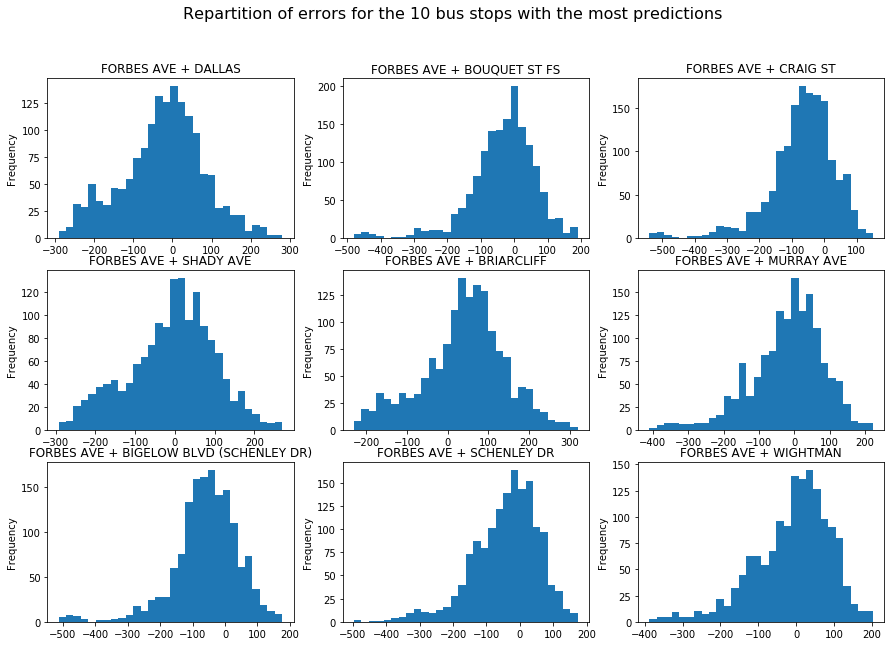

In [83]:
most_predicted_index = joined_errors.groupby('stop_id').count().nlargest(9, columns='error').index

figure = plt.figure(figsize=(15, 10))
figure.suptitle('Repartition of errors for the 10 bus stops with the most predictions', size=16)

for i, stop_id in enumerate(most_predicted_index):
    ax = figure.add_subplot(3, 3, i + 1)
    plot_error_hist(stop_id, joined_errors, ax)

The distribution of errors varies greatly between the different stops but always look somewhat like a Gaussian centered on something close to 0 which can be expected.

#### Prediction error vs. bus distance

As a sanity check, let's plot the prediction error against the distance between the bus and the prediction stop.
We expect the error to decrease the closer the bus is to the stop.

In [84]:
def time_plot(stop_id: int, ax=None):
    stop_error = joined_errors[joined_errors.stop_id == stop_id].groupby('trip_id')
    stop_error.plot.line(x='distance_to_stop', y='error', title=stop_infos.loc[stop_id]['name'],
                         ax=ax, legend=False, sharex=True)

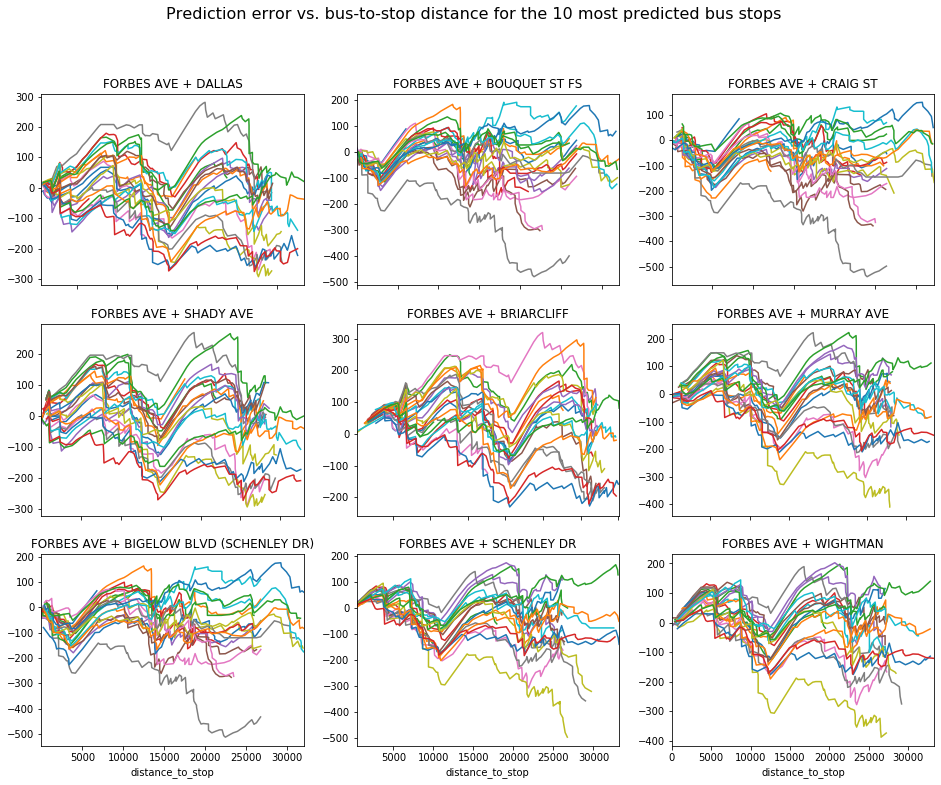

In [85]:
most_predicted_index = joined_errors.groupby('stop_id').count().nlargest(9, columns='error').index

figure = plt.figure(figsize=(16, 12))
figure.suptitle('Prediction error vs. bus-to-stop distance for the 10 most predicted bus stops', size=16)

for i, stop_id in enumerate(most_predicted_index):
    ax = figure.add_subplot(3, 3, i + 1)
    time_plot(stop_id, ax)

Although the prediction quality varies a lot between trips the predictions go to zero the closer the bus is to the stop.
Note that every stop has its own curve of imprecision shape.

#### Geographical plot

In [91]:
renaming = {'name': 'Name',
            'number_of_predictions': 'Number of predictions',
            'absolute_error': 'Mean absolute error'}

joined = error_means.join(number_of_predictions).rename(columns=renaming)
joined.sort_values('Number of predictions')[renaming.values()]

,Name,Number of predictions,Mean absolute error
stop_id,,,
20937,7TH ST + BRADDOCK AVE,42,167.261905
7293,BRADDOCK AVE + 7TH,97,27.855670
20721,BRADDOCK AVE + LIBRARY,126,58.424603
19503,BALDRIDGE AVE + MIDDLE ST,167,33.098802
18994,Rankin Blvd past Kenmawr Ave,198,54.689394
...,...,...,...
7132,FORBES AVE + BRIARCLIFF,1521,89.841880
7127,FORBES AVE + SHADY AVE,1532,85.601501
7115,FORBES AVE + CRAIG ST,1536,88.026042


In [178]:
color_breaks = [round(joined['Mean absolute error'].quantile(q=x*0.1), 2) for x in range(1, 10, 2)]
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

radius_breaks = [round(joined['Number of predictions'].quantile(q=x*0.1), 2) for x in range(1, 11, 2)]
radius_stops = create_radius_stops(radius_breaks, 0.5, 10)

m = GraduatedCircleViz(
              access_token=MAPBOX_API_KEY,  
              data=df_to_geojson(joined, properties=['Name', 'Mean absolute error', 'Number of predictions'], precision=6),
              center=PITTSBURGH_COORDINATES,
              color_property='Mean absolute error',
              color_stops=color_stops,
              color_function_type='interpolate',
              stroke_width=0,
              radius_property='Number of predictions',
              radius_stops=radius_stops,
              radius_function_type='interpolate',
              zoom=12)

m.show()

#### Relative errors
One thing that we need to do is account for data imbalance.
The number and proportion of long-distance prediction is not uniform accross all bus stops.
As such I chose to introduce a relative measure of error `relative_error = absolute_error / distance`

In [173]:
joined_errors['relative_error'] = joined_errors['absolute_error'] / joined_errors['distance_to_stop'] * 10000

renaming = {'name': 'Name',
            'number_of_predictions': 'Number of predictions',
            'absolute_error': 'Mean absolute error',
            'relative_error': 'Mean relative error'}

joined = joined_errors.groupby('stop_id').mean().join(stop_infos).join(number_of_predictions).rename(columns=renaming)
joined.sort_values('Number of predictions')[renaming.values()]

,Name,Number of predictions,Mean absolute error,Mean relative error
stop_id,,,,
20937,7TH ST + BRADDOCK AVE,42,167.261905,14047.122002
7293,BRADDOCK AVE + 7TH,97,27.855670,51.693973
20721,BRADDOCK AVE + LIBRARY,126,58.424603,741.855847
19503,BALDRIDGE AVE + MIDDLE ST,167,33.098802,84.386642
18994,Rankin Blvd past Kenmawr Ave,198,54.689394,104.833689
...,...,...,...,...
7132,FORBES AVE + BRIARCLIFF,1521,89.841880,64.766635
7127,FORBES AVE + SHADY AVE,1532,85.601501,102.389481
7115,FORBES AVE + CRAIG ST,1536,88.026042,102.416454


In [179]:
color_breaks = [round(joined['Mean relative error'].quantile(q=x*0.1), 2) for x in range(1, 10, 2)]
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

radius_breaks = [round(joined['Number of predictions'].quantile(q=x*0.1), 2) for x in range(1, 11, 2)]
radius_stops = create_radius_stops(radius_breaks, 0.5, 10)

m = GraduatedCircleViz(
              access_token=MAPBOX_API_KEY,  
              data=df_to_geojson(joined, properties=['Name', 'Mean absolute error', 'Mean relative error', 'Number of predictions'], precision=6),
              center=PITTSBURGH_COORDINATES,
              color_property='Mean relative error',
              color_stops=color_stops,
              color_function_type='interpolate',
              stroke_width=0,
              radius_property='Number of predictions',
              radius_stops=radius_stops,
              radius_function_type='interpolate',
              zoom=12)

m.show()

We can observe that it leads to slighty smoother color transitions between adjacent stops.
Because the distances in Downtown are short and the prediction errors important its stops have a high relative error.

#### Conclusion
With an RMSE of 109 seconds, BusTime predictions are far from being perfect especially in busy zones like Downtown and Oakland.

## Part 3: Predictive modeling

In [103]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor

#### Data collection
The data collection loop is very similar to that of the previous part except we don't request the prediction times from the API.
As the prediction collection is the main driver of number of API calls I chose to decrease the sampling period from 5 seconds to 3 seconds.

See `gather_bus_updates.py` for the stand-alone data scraper code.

#### Data Loading

This data comes from 6 3h sessions of gathering the information of running buses on the `61` and `71` lines on week days every 3 seconds.

In [176]:
BUS_UPDATES_FILE = 'bus_updates_concatenated.csv'

In [177]:
# Drop the index column
update_columns = ['id', 'timestamp', 'lat', 'lon', 'destination',
                  'pattern_id', 'pattern_distance','trip_id', 'speed']

bus_updates = pd.read_csv(BUS_UPDATES_FILE,
                          index_col=False, usecols=update_columns,
                          parse_dates=['timestamp'])

In [138]:
patterns = get_stops_for_more_than_10_patterns(bus_updates.pattern_id.unique().astype(str))
stop_times = compute_stop_times(bus_updates, patterns)
stop_infos = stop_infos_from_patterns(patterns)

#### Features building

I did very few feature transformation: I dropped the date component of the timestamp and converted the time to a single float (e.g. 18:30 becomes 18.5).

I chose to drop training data that are predicting a bus more than 30 minutes in advance as I think it is not very useful to predict past this threshold. It makes the problem easier as well.

In [141]:
def dist_in_patterns(stop_id: int, patterns: Dict):
    """
    Return the position of the stop in each pattern.
    """
    
    dist_for_patterns = {}

    for pattern_id, stops in patterns.items():
        for stop in stops:
            if stop['id'] == stop_id:
                dist_for_patterns[pattern_id] = stop['distance']
                break
    
    return dist_for_patterns

In [142]:
def features_for_stop(stop_id: int, bus_updates: pd.DataFrame):
    labels = []
    distance_to_stop = []
    dist_for_patterns = dist_in_patterns(stop_id, patterns)

    for update in bus_updates.itertuples():
        unique_key = str(update.timestamp.date()) + '-' + str(update.trip_id)

        if unique_key in stop_times and stop_id in stop_times[unique_key] and update.pattern_distance > 0 and update.speed < 100:
            # Remove outliers, drop bad data and don't train further than 30 minutes
            if stop_times[unique_key][stop_id] > update.timestamp.timestamp() \
            and stop_times[unique_key][stop_id] - update.timestamp.timestamp() <= 1800 \
            and (dist_for_patterns[update.pattern_id] - update.pattern_distance) >= 0:
                labels.append({'truth': stop_times[unique_key][stop_id] - update.timestamp.timestamp()})
                distance_to_stop.append(dist_for_patterns[update.pattern_id] - update.pattern_distance)
            else:
                labels.append({'truth': -1})            
        else:
            labels.append({'truth': -1})

    labels = pd.DataFrame(labels)
    curated = bus_updates.copy()[(labels.truth != -1) & (labels.truth <= 1800)]
    labels = labels[(labels.truth != -1) & (labels.truth <= 1800)]
    
    curated['hour'] = curated['timestamp'].dt.hour + curated['timestamp'].dt.minute / 60
    curated['distance_to_stop'] = distance_to_stop
    
    # Keep only interesting features
    features = curated.drop(['timestamp', 'id', 'lat', 'lon', 'speed', 'pattern_distance', 'destination'], axis=1)
    
    return features, labels

In [143]:
def plot_features_for_stop(stop_id: int, bus_updates: pd.DataFrame, ax=None):
    features, labels = features_for_stop(stop_id, bus_updates)
    features['label'] = labels
    features.plot.scatter(x='distance_to_stop', y='label', c='hour', title=stop_infos.loc[stop_id]['name'],
                          colormap='viridis', ax=ax)    

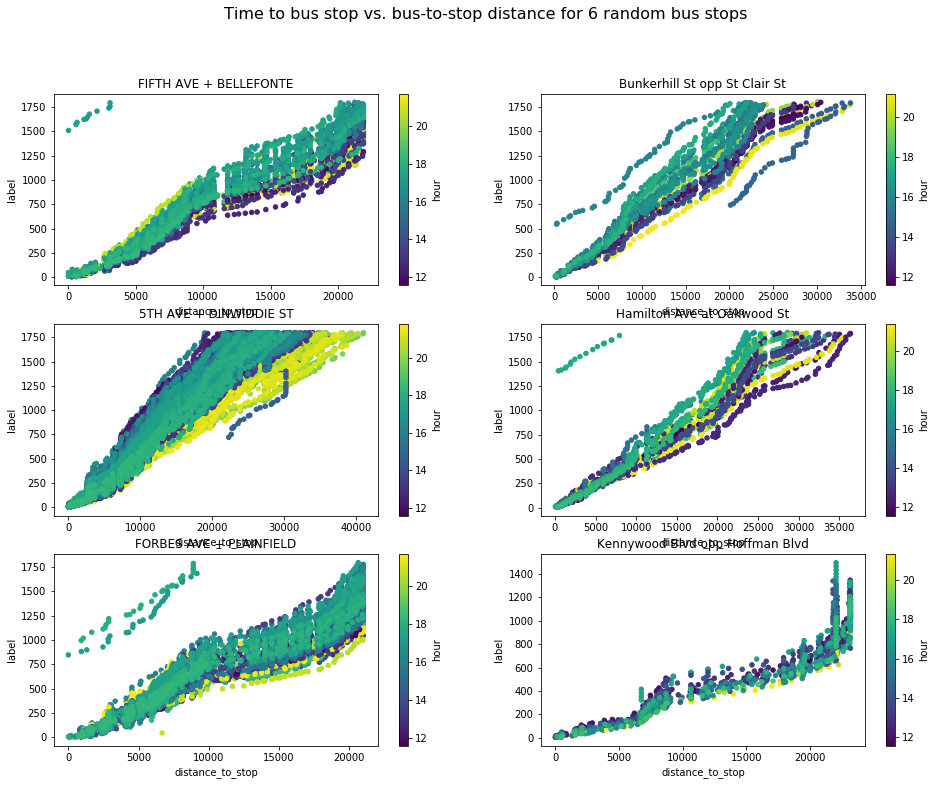

In [144]:
random_stop_ids = stop_infos.sample(6).index

figure = plt.figure(figsize=(16, 12))
figure.suptitle('Time to bus stop vs. bus-to-stop distance for 6 random bus stops', size=16)

for i, stop_id in enumerate(random_stop_ids):
    ax = figure.add_subplot(3, 2, i + 1)
    plot_features_for_stop(stop_id, bus_updates, ax)

We can observe that every stop has a specific pattern that we could try to learn to provide predictions.

That is why I chose not to train a general model as every stop has its own peculiarities.

In [119]:
def cross_validate_fit(features, labels, k: int = 10):
    # Evaluate features with K-fold cross validation
    # The higher k is, the longer it takes to run, and the higher the confidence in the score
    model = XGBRegressor(objective ='reg:squarederror')
    scores = cross_val_score(model, features, labels, cv=k, scoring='neg_mean_squared_error', verbose=False)
    average_rmse = np.sqrt(abs(np.mean(scores)))
    
    return model, average_rmse

In [123]:
stop_ids = set()

for p in stop_times.values():
    for s in p.keys():
        stop_ids.add(s)

models = {}
k = 5

for stop_id in tqdm(stop_ids):
    features, labels = features_for_stop(stop_id, bus_updates)
    
    # Cannot have number of splits k greater than the number of samples.
    if len(features) < k:
        continue
    
    model, average_rmse = cross_validate_fit(features, labels, k=k)    
    models[stop_id] = {'model': model, 'average_rmse': average_rmse, 'number_of_samples': len(features)}

models = pd.DataFrame(models).transpose()

100%|██████████| 609/609 [13:41<00:00,  1.35s/it]


In [127]:
models.sort_values('average_rmse')

,model,average_rmse,number_of_samples
20691,"XGBRegressor(base_score=0.5, booster='gbtree',...",39.9026,840
20293,"XGBRegressor(base_score=0.5, booster='gbtree',...",44.3443,2131
3241,"XGBRegressor(base_score=0.5, booster='gbtree',...",55.7383,3529
3246,"XGBRegressor(base_score=0.5, booster='gbtree',...",58.3996,4718
7114,"XGBRegressor(base_score=0.5, booster='gbtree',...",62.2047,4265
...,...,...,...
20690,"XGBRegressor(base_score=0.5, booster='gbtree',...",296.634,1790
19850,"XGBRegressor(base_score=0.5, booster='gbtree',...",342.73,5087
2557,"XGBRegressor(base_score=0.5, booster='gbtree',...",352.028,4514
20294,"XGBRegressor(base_score=0.5, booster='gbtree',...",362.834,1033


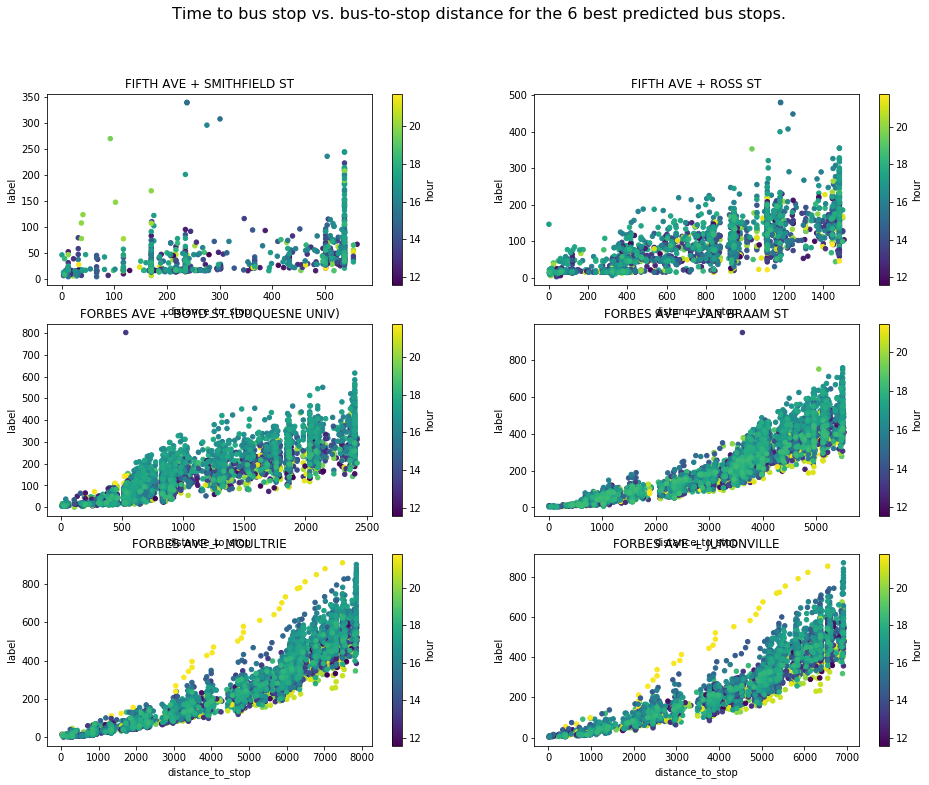

In [145]:
best_predictions_index = models.sort_values('average_rmse').head(6).index

figure = plt.figure(figsize=(16, 12))
figure.suptitle('Time to bus stop vs. bus-to-stop distance for the 6 best predicted bus stops.', size=16)

for i, stop_id in enumerate(best_predictions_index):
    ax = figure.add_subplot(3, 2, i + 1)
    plot_features_for_stop(stop_id, bus_updates, ax)

In [158]:
best_6 = models.sort_values('average_rmse').head(6)

error_means.loc[best_6.index]

for m in best_6.itertuples():
    other = error_means.loc[m.Index]

    if math.sqrt(other['absolute_error_squared']) > m.average_rmse:
        print('Our prediction is better for', other['name'])
    else:
        print('Their prediction is better for', other['name'])

Our prediction is better for FIFTH AVE + SMITHFIELD ST
Our prediction is better for FIFTH AVE + ROSS ST
Our prediction is better for FORBES AVE + BOYD ST (DUQUESNE UNIV)
Our prediction is better for FORBES AVE + VAN BRAAM ST
Our prediction is better for FORBES AVE + MOULTRIE
Our prediction is better for FORBES AVE + JUMONVILLE


It seems like I managed to make a better prediction model for these stops.

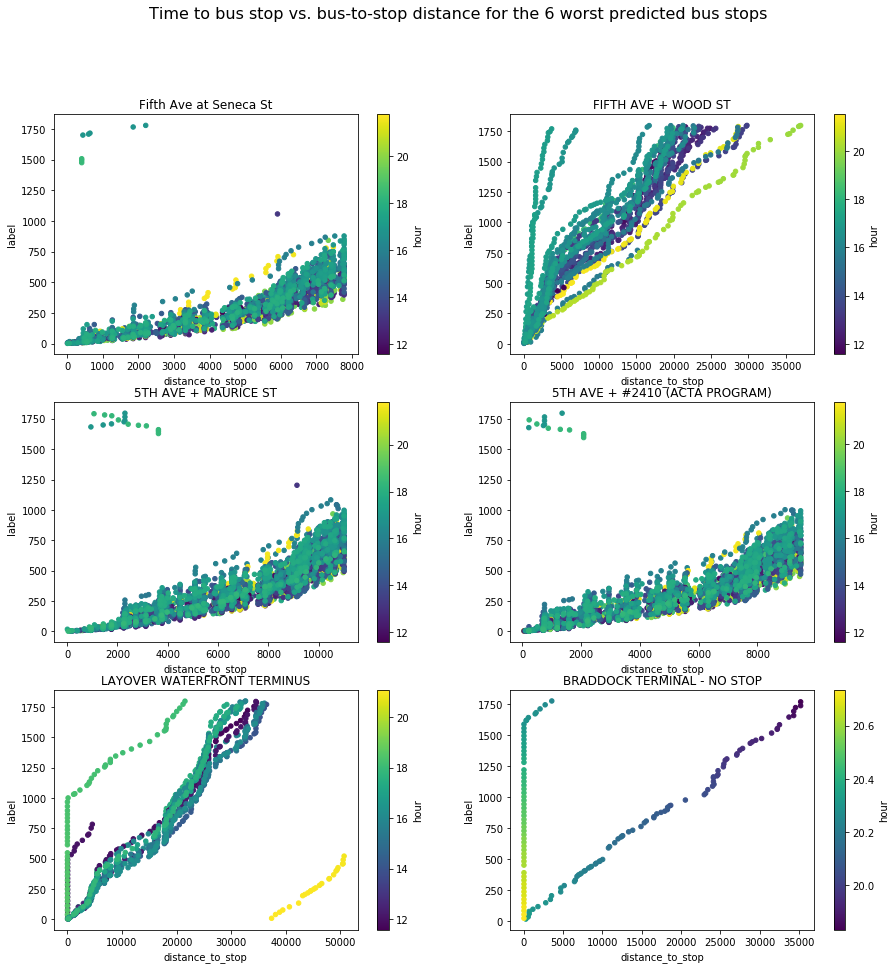

In [134]:
worst_predictions_index = models.sort_values('average_rmse').tail(6).index

figure = plt.figure(figsize=(16, 12))
figure.suptitle('Time to bus stop vs. bus-to-stop distance for the 6 worst predicted bus stops', size=16)

for i, stop_id in enumerate(worst_predictions_index):
    ax = figure.add_subplot(3, 2, i + 1)
    plot_features_for_stop(stop_id, bus_updates, ax)

XGBoost seems to be sensitive to outliers as the worst predicted stops all seem to have some.

In [135]:
print('Average RMSE:', models['average_rmse'].mean())

Average RMSE: 119.41100706676535


Although this RMSE value is not strictly identical to the one computed in the previous part it shows that our prediction are not a lot better on average compared to the existing system.

This was expected as I am using XGBooster without any parameter tuning and the data could be cleaned more thoroughly.

## Conclusions
The BusTime API is a joy to work with and it is possible to build some nice notebooks in a timely manner.
Pittsburgh bus predictions are far from being perfect but my simple try using XGBoosting shows that it's not trivial to generate accurate predictions.

I suspect BusTime's algorithm to be quite simple and not tailored to each bus stop. Maybe there exists some literature about their implementation but I wasn't able to find it.

### Further investigations
- I would have liked to try other models. More precisely, I would have loved to train a LSTM neural network with more data.
- It would be interesting to play with other routes.
- It would be interesting to compare the quality of the predictions at different times of the day and/or the week and/or the month.
- A continuous dataset over a full month would've been more interesting.
- It's hard to know how good my stop time calculations are. The algorithm could probably be made more accurate.

## Appendix

### Part 1: Data Collection

#### Datafeeds

In [126]:
DATAFEEDS_ENDPOINT = '/getrtpidatafeeds'

def get_datafeeds_list():
    return query_api(DATAFEEDS_ENDPOINT)['rtpidatafeeds']

pd.DataFrame(get_datafeeds_list())

,name,source,displayname,enabled,visible
0,Light Rail,BUSTIMEPID,Light Rail,true,true
1,bustime,TrueTime,PAAC,false,true
2,Port Authority Bus,BUSTIMEPID,Port Authority Bus,true,true


#### Directions

In [160]:
def get_directions(route_id):
    params = { 'rt': route_id }
    
    return query_api(DIRECTIONS_ENDPOINT, params)['directions']

pd.DataFrame(get_directions('61A'))

,id,name
0,INBOUND,INBOUND
1,OUTBOUND,OUTBOUND


### Part 2: Data Analysis

In [ ]:
def compute_stop_times_from_preds(preds: pd.DataFrame):
    stop_times = {}
    a = preds.sort_values('distance_to_stop').groupby(['stop_id', 'trip_id']).head(1)

    for e in a.itertuples():
        unique_key = str(e.timestamp.date()) + '-' + str(e.trip_id)

        if unique_key not in stop_times:
            stop_times[unique_key] = {}

        stop_times[unique_key][e.stop_id] = e.timestamp.timestamp()
    
    return stop_times